In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import MultivariateGaussianAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Gaussian/../utils.py'>

In [2]:
d = 20

In [3]:
# target 1

import pandas as pd

df = pd.read_csv('Corrmat_20DGaussian.csv', header = None)

ms = 3*np.ones(d)
Sigmas = 2*df.to_numpy()


# # target 2
# ms = 20*np.ones(d)
# Sigmas = 5*np.eye(d)

# initial distribution
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

In [4]:
linalg.eig(Sigmas)[0]

array([12.9665051 +0.j,  3.25272556+0.j,  2.8813329 +0.j,  2.71041441+0.j,
        2.52388121+0.j,  2.35958443+0.j,  2.17869881+0.j,  1.87416663+0.j,
        0.0398127 +0.j,  0.1374515 +0.j,  0.27295558+0.j,  0.36473422+0.j,
        0.50964599+0.j,  0.59895205+0.j,  1.59346172+0.j,  1.47736896+0.j,
        1.29178523+0.j,  0.884292  +0.j,  1.01159281+0.j,  1.07063818+0.j])

In [5]:
Sigmas_inv = linalg.inv(Sigmas)

## Algorithms

In [6]:
N = 50
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
gamma = 0.05

In [7]:
Niter = 100

# target 1
Niter_ula = Niter*18
Niter_mala = Niter*9
Niter_fr = Niter*4
Niter_smcula = Niter*14
Niter_smcmala = Niter*6

In [8]:
## target 1
gamma_mala = 0.07
gamma_smcmala = 0.06

In [9]:
Nalgo = 6
Nrep = 1

runtime = np.zeros((Nrep, Nalgo))

kl_ula = np.zeros((Nrep, Niter_ula))
kl_mala = np.zeros((Nrep, Niter_mala))
kl_fr = np.zeros((Nrep, Niter_fr))
kl_wfr = np.zeros((Nrep, Niter))
kl_smcula = np.zeros((Nrep, Niter_smcula))
kl_smcmala = np.zeros((Nrep, Niter_smcmala))

In [10]:
for i in range(Nrep):
    ## ULA
    start = time.time()
    _, kl_ula[i, :] = algo.ParallelULA(gamma, Niter_ula, ms, Sigmas, Sigmas_inv, X0)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    _, accepted_mala, kl_mala[i, :] = algo.ParallelMALA(gamma_mala, Niter_mala, ms, Sigmas, Sigmas_inv, X0)
    end = time.time()
    runtime[i, 1] = end-start
    ### SMC-FR
    start = time.time()
    _, _, kl_fr[i, :] = algo.SMC_UnitFR(gamma, Niter_fr, ms, Sigmas, Sigmas_inv, X0, 1)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    _, _, kl_wfr[i, :] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, 1)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    _, _, kl_smcula[i, :] = algo.SMC_ULA(gamma, Niter_smcula, ms, Sigmas, Sigmas_inv, X0, 1)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    _, _, accepted_smcmala, kl_smcmala[i, :] = algo.SMC_MALA(gamma_smcmala, Niter_smcmala, ms, Sigmas, Sigmas_inv, X0, 1)
    end = time.time()
    runtime[i, 5] = end-start

In [11]:
np.mean(np.sum(accepted_mala, axis = 0)/Niter_mala)

0.5453111111111112

In [12]:
np.mean(np.sum(accepted_smcmala, axis = 0)/Niter_smcmala)

0.6157666666666667

In [13]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime[3]/avg_runtime

array([0.06949911, 0.04337493, 0.0412732 , 1.        , 0.08714353,
       0.04559648])

In [14]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

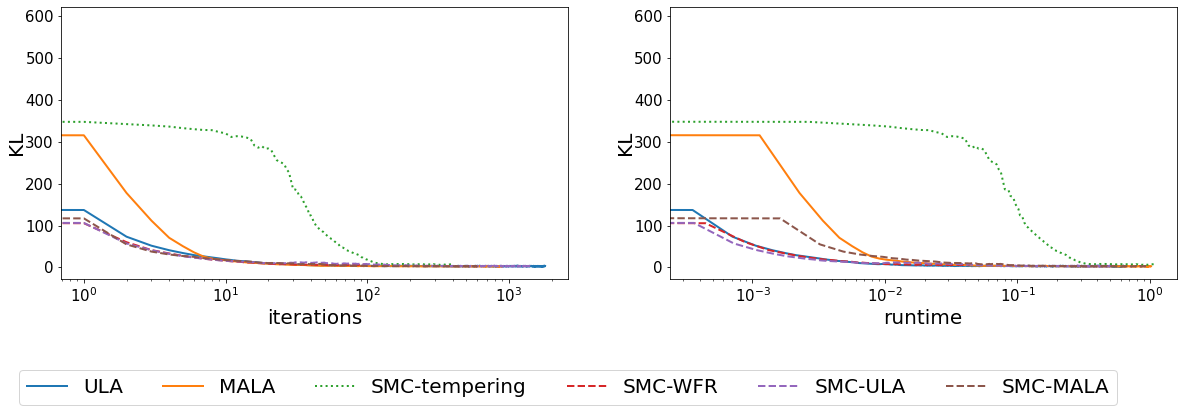

In [15]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.semilogx(np.mean(kl_ula, axis = 0), label = 'ULA', lw = 2)
plt.plot(np.mean(kl_mala, axis = 0), label = 'MALA', lw = 2)
plt.plot(np.mean(kl_fr, axis = 0), label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(np.mean(kl_wfr, axis = 0), label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(np.mean(kl_smcula, axis = 0), label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(np.mean(kl_smcmala, axis = 0), label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
# plt.plot(kl_wfr_exact, c = 'black', lw = 3)
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('KL', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.subplot(1, 2, 2)
plt.semilogx(xx_ula, np.mean(kl_ula, axis = 0), label = 'ULA', lw = 2)
plt.plot(xx_mala, np.mean(kl_mala, axis = 0), label = 'MALA', lw = 2)
plt.plot(xx_fr, np.mean(kl_fr, axis = 0), label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, np.mean(kl_wfr, axis = 0), label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, np.mean(kl_smcula, axis = 0), label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, np.mean(kl_smcmala, axis = 0), label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('KL', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('conv_iter_gm20D.pdf', bbox_inches="tight")

In [16]:
import pandas as pd

In [17]:
# df = pd.DataFrame(np.concatenate((kl_ula, xx_ula[:, np.newaxis].T)));
# df.to_csv("20DG1_ula.csv", index=False)

# df = pd.DataFrame(np.concatenate((kl_mala, xx_mala[:, np.newaxis].T)));
# df.to_csv("20DG1_mala.csv", index=False)

# df = pd.DataFrame(np.concatenate((kl_fr, xx_fr[:, np.newaxis].T)));
# df.to_csv("20DG1_fr.csv", index=False)

# df = pd.DataFrame(np.concatenate((kl_wfr, xx_wfr[:, np.newaxis].T)));
# df.to_csv("20DG1_wfr.csv", index=False)

# df = pd.DataFrame(np.concatenate((kl_smcula, xx_smcula[:, np.newaxis].T)));
# df.to_csv("20DG1_smcula.csv", index=False)

# df = pd.DataFrame(np.concatenate((kl_smcmala, xx_smcmala[:, np.newaxis].T)));
# df.to_csv("20DG1_smcmala.csv", index=False)